In [ ]:
import pandas as pd
import numpy as np
from collections import Counter
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
import torch
from torch.utils.data import Dataset, DataLoader
import torch.optim as torch_optim
import torch.nn as nn
import torch.nn.functional as F
from torchvision import models

In [ ]:
if torch.cuda.is_available():
  print(torch.cuda.device_count())            # Numero di GPU disponibili
  print(torch.cuda.get_device_name(0))        # Nome della prima GPU disponibile
  print(torch.cuda.current_device())          # Device in uso al momento
  print(torch.cuda.set_device(0))             # Imposta la prima GPU come default
  print(torch.cuda.get_device_capability(0))  # Verifica le capacità della prima GPU

1
Tesla T4
0
None
(7, 5)


In [ ]:
path = './drive/MyDrive/Materiale_Pellegrino_personal/CIDDS_Meta/CIDDS_Meta.csv'
dataset = pd.read_csv(path)

### ***PRE-ELABORAZIONE DATI***

In [ ]:
dataset

,Duration,Proto,Packets,Bytes,Flows,Flags,Tos,multilabel
0,0.245,TCP,2,670,1,.AP...,0,normal
1,0.000,TCP,1,66,1,.A....,0,normal
2,0.000,TCP,1,58,1,....S.,0,portScan
3,0.000,TCP,1,58,1,....S.,0,portScan
4,0.047,TCP,11,1027,1,.AP...,0,normal
...,...,...,...,...,...,...,...,...
399995,0.034,TCP,2,598,1,.AP...,0,normal
399996,0.000,TCP,1,95,1,.AP...,32,normal
399997,0.005,TCP,5,479,1,.AP.SF,0,dos
399998,0.000,TCP,1,66,1,.A...F,32,normal


In [ ]:
print(Counter(dataset['Flows']))
print(Counter(dataset['multilabel']))

dataset = dataset.drop('Flows', axis=1)

Counter({1: 400000})
Counter({'normal': 243363, 'dos': 117904, 'portScan': 37723, 'pingScan': 646, 'bruteForce': 364})


In [ ]:
dep_var = 'multilabel'
cat_names = ["Proto", "Flags", "Bytes"]
cont_names = [col for col in dataset.columns if col not in cat_names and col != dep_var]

print(cont_names, 'len: ', len(cont_names))

['Duration', 'Packets', 'Tos'] len:  3


In [ ]:
from sklearn.preprocessing import LabelEncoder

# LabelEncoding della variabile target 
target_index = dataset.columns.get_loc(dep_var)
dataset.iloc[:, target_index] = LabelEncoder().fit_transform(dataset[dep_var])

#LabelEncoding delle variabili categoriali
for col in cat_names:
  target_index = dataset.columns.get_loc(col)
  dataset.iloc[:, target_index] = LabelEncoder().fit_transform(dataset[col])

In [ ]:
cont_names = [col for col in dataset.columns if col != dep_var]

print(cont_names)

['Duration', 'Proto', 'Packets', 'Bytes', 'Flags', 'Tos']


In [ ]:
dataset.head()

,Duration,Proto,Packets,Bytes,Flags,Tos,multilabel
0,0.245,2,2,11030,12,0,2
1,0.000,2,1,10946,4,0,2
2,0.000,2,1,10024,1,0,4
3,0.000,2,1,10024,1,0,4
4,0.047,2,11,233,12,0,2


In [ ]:
print(Counter(dataset['multilabel']))

Counter({2: 243363, 1: 117904, 4: 37723, 3: 646, 0: 364})


In [ ]:
target_dict = {'bruteForce' : 0,
               'dos' : 1,
               'normal' : 2,
               'pingScan' : 3,
               'portScan' : 4}

In [ ]:
from sklearn.model_selection import train_test_split

# train 50% e test 50%
train, test = train_test_split(dataset, test_size=0.50)

In [ ]:
y_train = train[dep_var]
train = train.drop(dep_var, axis=1)
y_test = test[dep_var]
test = test.drop(dep_var, axis=1)

# validation di 2500 righe da train
train, validation, y_train, y_val = train_test_split(train, y_train, test_size=(10000/len(train)), random_state=0)

In [ ]:
"""Visto che nel dataset la variabile target è molto squilibrata lo amplio con una generazione
 randomica di dati mediante la tecnica chiamata Synthetic Minority Over-sampling Technique (SMOTE)"""

sampling_strategy = {0: 20000, 3: 20000}

from imblearn.over_sampling import SMOTE
sm = SMOTE(sampling_strategy = sampling_strategy, random_state=42)
x_sm, y_train = sm.fit_resample(train, y_train)
train = pd.DataFrame(x_sm,columns=train.columns)

/usr/local/lib/python3.7/dist-packages/sklearn/externals/six.py:31: FutureWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", FutureWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.neighbors.base module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.neighbors. Anything that cannot be imported from sklearn.neighbors is now part of the private API.
  warnings.warn(message, FutureWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
/usr/loca

In [ ]:
#y_train = y_train.values
y_test = y_test.values
y_val = y_val.values

print(Counter(y_train))
print(Counter(y_test))
print(Counter(y_val))

Counter({2: 115734, 1: 55890, 3: 20000, 0: 20000, 4: 17930})
Counter({2: 121550, 1: 59042, 4: 18863, 3: 351, 0: 194})
Counter({2: 6079, 1: 2972, 4: 930, 0: 12, 3: 7})


In [ ]:
train

,Duration,Proto,Packets,Bytes,Flags,Tos
0,0.018000,2.0,3.0,3950.0,13.0,0.0
1,0.007000,2.0,4.0,5177.0,7.0,0.0
2,0.002000,2.0,2.0,1531.0,5.0,32.0
3,0.026000,2.0,3.0,3408.0,13.0,0.0
4,0.000000,2.0,1.0,10946.0,4.0,32.0
...,...,...,...,...,...,...
229549,0.241000,0.0,2.0,12502.0,0.0,0.0
229550,0.000000,0.0,1.0,11364.0,0.0,192.0
229551,0.000000,0.0,1.0,11364.0,0.0,192.0
229552,0.000000,0.0,1.0,7848.0,0.0,0.0


In [ ]:
test

,Duration,Proto,Packets,Bytes,Flags,Tos
72721,0.000,2,1,10946,4,0
172505,0.003,2,5,8690,15,0
90849,0.000,3,2,1970,0,0
46057,0.004,2,3,3724,7,0
259380,0.130,2,5,12929,14,0
...,...,...,...,...,...,...
90198,0.723,2,11,3110,14,32
114847,0.004,3,2,2305,0,0
120967,0.000,3,2,2104,0,0
252512,0.026,2,2,1840,6,0


In [ ]:
validation

,Duration,Proto,Packets,Bytes,Flags,Tos
166766,0.004,2,6,9574,15,0
273943,0.000,2,1,9509,4,0
25638,0.236,2,3,12116,12,0
100011,0.000,2,1,10946,4,0
81396,0.000,2,1,11756,1,0
...,...,...,...,...,...,...
268755,0.006,2,5,8690,15,0
164563,0.052,2,7,12213,15,32
100991,0.000,2,1,10024,1,0
278213,0.207,2,4,7912,14,0


### ***GPU/CPU***

In [ ]:
""" Making device (GPU/CPU) compatible

(borrowed from https://jovian.ml/aakashns/04-feedforward-nn)

In order to make use of a GPU if available, we'll have to move our data and model to it. """ 

def get_default_device():
    """Pick GPU if available, else CPU"""
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')

def to_device(data, device):
    """Move tensor(s) to chosen device"""
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

class DeviceDataLoader():
    """Wrap a dataloader to move data to a device"""
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device
        
    def __iter__(self):
        """Yield a batch of data after moving it to device"""
        for b in self.dl: 
            yield to_device(b, self.device)

    def __len__(self):
        """Number of batches"""
        return len(self.dl)

device = get_default_device()
device

device(type='cuda')

### ***MODEL***

In [ ]:
""" Ghost Batch Normalization (GBN):
 Questa tenica ci consente di operare su grandi batch di dati e al tempo stesso ottenere buone generalizzazioni.
 In pratica: viene diviso il batch di in input in sotto-batch di dimensioni uguali (dimensione del batch 
 virtuale) e viene applicato lo stesso livello di Batch Normalization. 
 Tutti i layer di normalizzazione del modello, eccetto il primo, adottano questa tecnica. """

class GBN(nn.Module):
  def __init__(self,inp,vbs=128,momentum=1.0):
        super().__init__()
        self.bn = nn.BatchNorm1d(inp,momentum=momentum)
        self.vbs = vbs
        
  def forward(self,x):
        chunk = torch.chunk(x,x.size(0)//self.vbs,0)
        res = [self.bn(y) for y in chunk]
        return torch.cat(res,0)

""" SparseMax: 
  essa è una funzione di normalizzazione lineare come Softmax ma con una distribuzione più sparsa.
  Ovvero rispetto a Softmax alcuni numeri nella distribuzione della probabilità di output sono molto vicini
  a 1 mentre altri molto più vicini a 0; ciò consente al modello di selezionare le caratteristiche rilevanti in 
  ogni fase deciionale in modo più efficace. 
  Useremo Sparsemax per progettare la maschera per il passaggio di selezione delle features su uno spazio più ristretto. """

!pip install -U sparsemax

from sparsemax import Sparsemax

""" Attention Transformer: 
  è la fase in cui modelli apprendono la relazione tra le caratteristiche rilevanti e decidono quali trasferire al Feature Transformer.
  Ciascun Attention Transformer è costituito da: 
    - un livello completamente connesso;
    - un livello di GBN;
    - un livello Sparsemax.
  L'attention transformer in ogni fase decisionale riceve le caratteristiche di input, quelle elaborate nella fase precedente e le informazioni preliminari
  sulle caratteristiche utilizzate. 
  Tutte queste info sono rappresentate da una matrice di dim batch_size x input_features. Essa viene aggiornata in ogni fase decisionale.
  Esiste anche un parametro di "rilassamento" che limita il numero di volte in cui una determinata funzione può essere utilizzata in un passaggio in avanti. """

class AttentionTransformer(nn.Module):

    def __init__(self,d_a,inp_dim,relax,vbs=128):
        super().__init__()
        self.fc = nn.Linear(d_a,inp_dim)
        #self.bn = GBN(out_dim,vbs=vbs)
        self.bn = GBN(inp_dim, vbs=vbs)
        self.smax = Sparsemax()
        self.r = relax
    
    #a:feature from previous decision step
    
    def forward(self,a,priors): 
        a = self.bn(self.fc(a)) 
        mask = self.smax(a*priors) 
        priors =priors*(self.r-mask)  #updating the prior
        return mask

""" Feautre Transformer: 
 Il trasformatore di caratteristiche è dove tutte le caratteristiche selezionate vengono elaborate per generare l'output finale. 
 
 Ogni trasformatore di caratteristiche è composto da più Gated Linear Unit Blocks.
 Una GLU controlla quali informazioni devono essere autorizzate a fluire ulteriormente attraverso la rete. 
 Per implementare un blocco GLU, prima raddoppiamo la dimensione delle caratteristiche di input alla GLU utilizzando uno strato completamente connesso.
 Normalizziamo la matrice risultante utilizzando un GBN Layer. Quindi, applichiamo un sigmoide alla seconda metà delle caratteristiche risultanti 
 e moltiplichiamo i risultati per la prima metà. Il risultato viene moltiplicato per un fattore di scala (sqrt (0,5) in questo caso) e aggiunto all'input. 
 Questo risultato sommato è l'input per il blocco GLU successivo nella sequenza.

 Un certo numero di blocchi GLU è condiviso tra tutte le fasi decisionali per promuovere la capacità e l'efficienza del modello (opzionale). 
 Il primo blocco GLU condiviso (o il primo blocco indipendente se non ci sono blocchi condivisi) è unico in quanto riduce la dimensione 
 delle features di input ad una dimensione uguale n_a + n_d. 
 n_a è la dimensione delle caratteristiche in ingresso al trasformatore di attenzione del passaggio successivo e 
 n_d è la dimensione delle caratteristiche utilizzate per calcolare i risultati finali. 
 Queste caratteristiche vengono elaborate insieme fino a raggiungere lo splitter. 
 L'attivazione di ReLU viene applicata al vettore dimensionato n_d. 
 Gli output di tutte le fasi decisionali vengono sommati e passati attraverso un livello completamente connesso per mapparli alla dimensione di output. """

class GLU(nn.Module):

  def __init__(self,inp_dim,out_dim,fc=None,vbs=128):
      super().__init__()
      if fc:
          self.fc = fc
      else:
          self.fc = nn.Linear(inp_dim,out_dim*2)
      self.bn = GBN(out_dim*2,vbs=vbs) 
      self.od = out_dim

  def forward(self,x):
      x = self.bn(self.fc(x))
      return x[:,:self.od]*torch.sigmoid(x[:,self.od:])

class FeatureTransformer(nn.Module):

  def __init__(self,inp_dim,out_dim,shared,n_ind,vbs=128):
      super().__init__()
      first = True
      self.shared = nn.ModuleList()
      if shared:
          self.shared.append(GLU(inp_dim,out_dim,shared[0],vbs=vbs))
          first= False    
          for fc in shared[1:]:
              self.shared.append(GLU(out_dim,out_dim,fc,vbs=vbs))
      else:
          self.shared = None
      self.independ = nn.ModuleList()
      if first:
          self.independ.append(GLU(inp,out_dim,vbs=vbs))
      for x in range(first, n_ind):
          self.independ.append(GLU(out_dim,out_dim,vbs=vbs))
      self.scale = torch.sqrt(torch.tensor([.5],device=device))

  def forward(self,x):
      if self.shared:
          x = self.shared[0](x)
          for glu in self.shared[1:]:
              x = torch.add(x, glu(x))
              x = x*self.scale
      for glu in self.independ:
          x = torch.add(x, glu(x))
          x = x*self.scale
      return x
      
""" Combiniamo Attention Transformer e Feature Transformer in un DecisionStep """

class DecisionStep(nn.Module):
  
    def __init__(self,inp_dim,n_d,n_a,shared,n_ind,relax,vbs=128):
        super().__init__()
        self.fea_tran = FeatureTransformer(inp_dim,n_d+n_a,shared,n_ind,vbs)
        self.atten_tran =  AttentionTransformer(n_a,inp_dim,relax,vbs)
    
    def forward(self,x,a,priors):
        mask = self.atten_tran(a,priors)
        sparse_loss = ((-1)*mask*torch.log(mask+1e-10)).mean()
        x = self.fea_tran(x*mask)
        return x,sparse_loss

Requirement already up-to-date: sparsemax in /usr/local/lib/python3.7/dist-packages (0.1.9)


In [ ]:
""" Creiamo ora il modello completo mediante gli elementi definiti """

class TabNet(nn.Module):
    def __init__(self,inp_dim, final_out_dim, n_d=64, n_a=64, n_shared=3, n_ind=2, n_steps=5, relax=1.2, vbs=128):
        super().__init__()
        if n_shared>0:
            self.shared = nn.ModuleList()
            self.shared.append(nn.Linear(inp_dim,2*(n_d+n_a)))
            for x in range(n_shared-1):
                self.shared.append(nn.Linear(n_d+n_a,2*(n_d+n_a)))
        else:
            self.shared=None
        self.first_step = FeatureTransformer(inp_dim,n_d+n_a,self.shared,n_ind) 
        self.steps = nn.ModuleList()
        for x in range(n_steps-1):
            self.steps.append(DecisionStep(inp_dim,n_d,n_a,self.shared,n_ind,relax,vbs))
        self.fc = nn.Linear(n_d,final_out_dim)
        self.bn = nn.BatchNorm1d(inp_dim, momentum=1.0)
        self.n_d = n_d

    def forward(self,x):
        x = self.bn(x)
        x_a = self.first_step(x)[:,self.n_d:]
        sparse_loss = torch.zeros(1).to(x.device)
        out = torch.zeros(x.size(0),self.n_d).to(x.device)
        priors = torch.ones(x.shape).to(x.device)
        for step in self.steps:
            x_te,l = step(x,x_a,priors)
            out += F.relu(x_te[:,:self.n_d])
            x_a = x_te[:,self.n_d:]
            sparse_loss += l
        return self.fc(out),sparse_loss

In [ ]:
""" Pytorch Dataset e DataLoader
Estendiamo la Datasetclasse (astratta) fornita da Pytorch per un accesso più facile al nostro set di dati durante l'addestramento 
e per utilizzare efficacemente  il DataLoader modulo per gestire i batch. Ciò comporta la sovrascrittura dei metodi __len__e __getitem__
secondo il nostro particolare set di dati.
Poiché abbiamo solo bisogno di incorporare colonne categoriali, dividiamo il nostro input in due parti: numerico e categoriale. """ 

class CIDDS_Dataset(Dataset):
    def __init__(self, X, Y):
        X = X.copy()
        self.X = X.copy().values.astype(np.float32) #numerical columns
        self.y = Y
        
    def __len__(self):
        return len(self.y)
    
    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]
        
#creating train and valid datasets
train_ds = CIDDS_Dataset(train, y_train)
valid_ds = CIDDS_Dataset(validation, y_val)

In [ ]:
""" Fase di preparazione per l'addestramento """

# Optimizer
def get_optimizer(model, lr = 0.001, wd = 0.0):
    parameters = filter(lambda p: p.requires_grad, model.parameters())
    optim = torch_optim.Adam(parameters, lr=lr, weight_decay=wd)
    return optim

# Training function
def train_model(model, optim, train_dl):
    model.train()
    total = 0
    sum_loss = 0
    for x, y in train_dl:
        batch = y.shape[0]
        output, _ = model(x)
        loss = F.cross_entropy(output, y)
        optim.zero_grad()
        loss.backward()
        optim.step()
        total += batch
        sum_loss += batch*(loss.item())
    return sum_loss/total

# Evaluation function
def val_loss(model, valid_dl):
    model.eval()
    total = 0
    sum_loss = 0
    correct = 0
    for x, y in valid_dl:
        current_batch_size = y.shape[0]
        out,_ = model(x)
        loss = F.cross_entropy(out, y)
        sum_loss += current_batch_size*(loss.item())
        total += current_batch_size
        pred = torch.max(out, 1)[1]
        correct += (pred == y).float().sum().item()
    #print("valid loss %.3f and accuracy %.3f" % (sum_loss/total, correct/total))
    print('valid loss ', sum_loss/total, ' and accuracy ', correct/total)
    return sum_loss/total, correct/total

# Funzione per l'addestramento 
def train_loop(model, epochs, lr=0.01, wd=0.0):
    optim = get_optimizer(model, lr = lr, wd = wd)
    for i in range(epochs): 
        loss = train_model(model, optim, train_dl)
        print("ep ", i, " training loss: ", loss)
        val_loss(model, valid_dl)

### ***TRAINING***

In [ ]:
print('Lunghezza train: ', len(train))
print('Lunghezza validation: ', len(validation))
print('Lunghezza test: ', len(test))

Lunghezza train:  229554
Lunghezza validation:  10000
Lunghezza test:  200000


In [ ]:
""" Ora addestriamo il modello sul set di addestramento. Ho usato l'ottimizzatore Adam per ottimizzare la perdita di entropia incrociata. 
L'addestramento è piuttosto semplice: iterare attraverso ogni batch, eseguire un passaggio in avanti, calcolare i gradienti, 
eseguire una discesa del gradiente e ripetere questo processo per tutte le epoche necessarie. """

# Per TabNet ogni singolo batch deve essere di lunghezza >= a 128 (che sarebbe il vbs)

batch_size = 514
train_dl = DataLoader(train_ds, batch_size=batch_size,shuffle=True)
valid_dl = DataLoader(valid_ds, batch_size=batch_size,shuffle=True)

train_dl = DeviceDataLoader(train_dl, device)
valid_dl = DeviceDataLoader(valid_dl, device)

In [ ]:
model = TabNet(inp_dim=len(cont_names), final_out_dim=5)
to_device(model, device)

TabNet(
  (shared): ModuleList(
    (0): Linear(in_features=6, out_features=256, bias=True)
    (1): Linear(in_features=128, out_features=256, bias=True)
    (2): Linear(in_features=128, out_features=256, bias=True)
  )
  (first_step): FeatureTransformer(
    (shared): ModuleList(
      (0): GLU(
        (fc): Linear(in_features=6, out_features=256, bias=True)
        (bn): GBN(
          (bn): BatchNorm1d(256, eps=1e-05, momentum=1.0, affine=True, track_running_stats=True)
        )
      )
      (1): GLU(
        (fc): Linear(in_features=128, out_features=256, bias=True)
        (bn): GBN(
          (bn): BatchNorm1d(256, eps=1e-05, momentum=1.0, affine=True, track_running_stats=True)
        )
      )
      (2): GLU(
        (fc): Linear(in_features=128, out_features=256, bias=True)
        (bn): GBN(
          (bn): BatchNorm1d(256, eps=1e-05, momentum=1.0, affine=True, track_running_stats=True)
        )
      )
    )
    (independ): ModuleList(
      (0): GLU(
        (fc): Linea

In [ ]:
train_loop(model, epochs=100, lr=0.00008)

ep  0  training loss:  0.6952889995326171
valid loss  0.3003783659517765  and accuracy  0.9322
ep  1  training loss:  0.1982834549475325
valid loss  0.17024638799205422  and accuracy  0.9765
ep  2  training loss:  0.12407687788163146
valid loss  0.08947699017375707  and accuracy  0.9717
ep  3  training loss:  0.09553079374651058
valid loss  0.0742650535389781  and accuracy  0.9735
ep  4  training loss:  0.08252067035722406
valid loss  0.06807315890714526  and accuracy  0.9784
ep  5  training loss:  0.0737425589083251
valid loss  0.059395161545276645  and accuracy  0.981
ep  6  training loss:  0.07183920795050998
valid loss  0.052211696746200326  and accuracy  0.983
ep  7  training loss:  0.07718692168815605
valid loss  0.05243950687944889  and accuracy  0.9836
ep  8  training loss:  0.06388973029156259
valid loss  0.057721282438933846  and accuracy  0.9834
ep  9  training loss:  0.05836090886604329
valid loss  0.06776851931214332  and accuracy  0.9791
ep  10  training loss:  0.05669140

30 min 20 sec

### ***PREDICTION***

In [ ]:
""" Effettuiamo le predizioni sul dataset di test """

batch_size = 512
test_ds = CIDDS_Dataset(test, np.zeros(len(test)))
test_dl = DataLoader(test_ds, batch_size=batch_size)
test_dl = DeviceDataLoader(test_dl, device)

# Utilizziamo la funzione softmax poiché siamo interessati alla probabilità per ogni classe
preds = []
model.eval()
with torch.no_grad():
    for x, y in test_dl:
        out = model(x)
        prob = F.softmax(out[0], dim=1)
        preds.append(prob)
        
y_pred = []
for i in range(0, len(preds)):
  pred = preds[i].cpu()
  temp = np.argmax(pred, 1)
  temp = np.array(temp)
  y_pred = np.append(y_pred, temp)

y_pred = y_pred.astype(int)

In [ ]:
y_pred

array([2, 1, 2, ..., 2, 2, 1])

### ***EVALUATION***

In [ ]:
print('Test:', Counter(y_test))
print('Pred:', Counter(y_pred))

Test: Counter({2: 121550, 1: 59042, 4: 18863, 3: 351, 0: 194})
Pred: Counter({2: 121371, 1: 59040, 4: 18498, 3: 747, 0: 344})


In [ ]:
# Matrice di confusione, accuracy, classification_report
from sklearn.metrics import *

# y_test è la variabile che contiene i valori effettivi
# y_pred contiene i valori predetti dal modello
cm = confusion_matrix(y_test, y_pred)
report = classification_report(y_test, y_pred)

acc = accuracy_score(y_test, y_pred)
mcc = matthews_corrcoef(y_test, y_pred)
recall = recall_score(y_test, y_pred, average='weighted')
precision = precision_score(y_test, y_pred, average='weighted')
# non presente nella libreria, calcolo mediante formula
f2 = (1+2**2)*((precision*recall)/((2**2*precision)+recall))

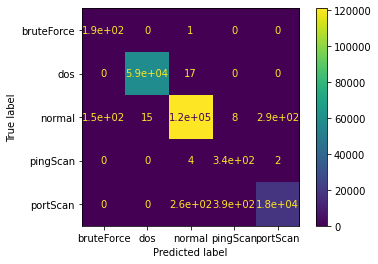

In [ ]:
from sklearn.metrics import ConfusionMatrixDisplay

disp = ConfusionMatrixDisplay(cm, target_dict)
disp.plot()

In [ ]:
mcm = multilabel_confusion_matrix(y_test, y_pred)
print(mcm)

[[[199655    151]
  [     1    193]]

 [[140943     15]
  [    17  59025]]

 [[ 78166    284]
  [   463 121087]]

 [[199247    402]
  [     6    345]]

 [[180846    291]
  [   656  18207]]]


In [ ]:
FP = cm.sum (axis = 0) - np.diag (cm) 
FN = cm.sum (axis = 1) - np.diag (cm) 
TP = np.diag (cm) 
TN = cm.sum () - (FP + FN + TP)

print('True positive: ', TP)
print('True negative: ', TN)
print('False positive: ', FP)
print('False negative: ', FN)

FP = FP.astype(float)
FN = FN.astype(float)
TP = TP.astype(float)
TN = TN.astype(float)

# Sensitivity, hit rate, recall, or true positive rate
TPR = TP/(TP+FN)
# Specificity or true negative rate
TNR = TN/(TN+FP) 
# Fall out or false positive rate
FPR = FP/(FP+TN)
# False negative rate
FNR = FN/(TP+FN)

print('True positive rate: ', TPR)
print('True negative rate: ', TNR)
print('False positive rate: ', FPR)
print('False negative rate: ', FNR)

True positive:  [   193  59025 121087    345  18207]
True negative:  [199655 140943  78166 199247 180846]
False positive:  [151  15 284 402 291]
False negative:  [  1  17 463   6 656]
True positive rate:  [0.99484536 0.99971207 0.99619087 0.98290598 0.96522292]
True negative rate:  [0.99924427 0.99989359 0.99637986 0.99798647 0.99839348]
False positive rate:  [0.00075573 0.00010641 0.00362014 0.00201353 0.00160652]
False negative rate:  [0.00515464 0.00028793 0.00380913 0.01709402 0.03477708]


In [ ]:
print(cm)

[[   193      0      1      0      0]
 [     0  59025     17      0      0]
 [   151     15 121087      8    289]
 [     0      0      4    345      2]
 [     0      0    262    394  18207]]


In [ ]:
print(report)

              precision    recall  f1-score   support

           0       0.56      0.99      0.72       194
           1       1.00      1.00      1.00     59042
           2       1.00      1.00      1.00    121550
           3       0.46      0.98      0.63       351
           4       0.98      0.97      0.97     18863

    accuracy                           0.99    200000
   macro avg       0.80      0.99      0.86    200000
weighted avg       1.00      0.99      0.99    200000



In [ ]:
print('Accuracy: ', acc)
print('Precision_weighted: ', precision)
print('Recall_weighted: ', recall)
print('mcc: ', mcc)
print('f2: ', f2)

Accuracy:  0.994285
Precision_weighted:  0.995648950643803
Recall_weighted:  0.994285
mcc:  0.9893327046994859
f2:  0.9945574910882277
